#  NAIVE BAYES CLASSIFIER ALGORITHM

# 

# 

In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.metrics import roc_curve, auc, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
def calculate_mean_var(X):
    mean = X.mean(axis=0)
    var = X.var(axis=0) + 1e-9
    return mean, var


def calculate_class_prob(y):
    n_samples = len(y)
    class_prob = np.zeros(2)
    class_prob[0] = np.sum(y == 0) / n_samples
    class_prob[1] = np.sum(y == 1) / n_samples
    return class_prob


def calculate_likelihood(X, mean, var):
    var = np.where(var <= 0, 1e-9, var)
    likelihood = np.exp(-((X - mean)**2) / (2 * var)) / np.sqrt(2 * np.pi * var)
    return likelihood


def predict(X, class_prob, mean, var):
    class_cond_prob = np.zeros((len(X), 2))
    class_cond_prob[:, 0] = np.prod(calculate_likelihood(X, mean[0], var[0]), axis=1) * class_prob[0]
    class_cond_prob[:, 1] = np.prod(calculate_likelihood(X, mean[1], var[1]), axis=1) * class_prob[1]

    y_pred = np.argmax(class_cond_prob, axis=1)
    return y_pred

In [3]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-white.csv"
data = pd.read_csv(url, sep=';')

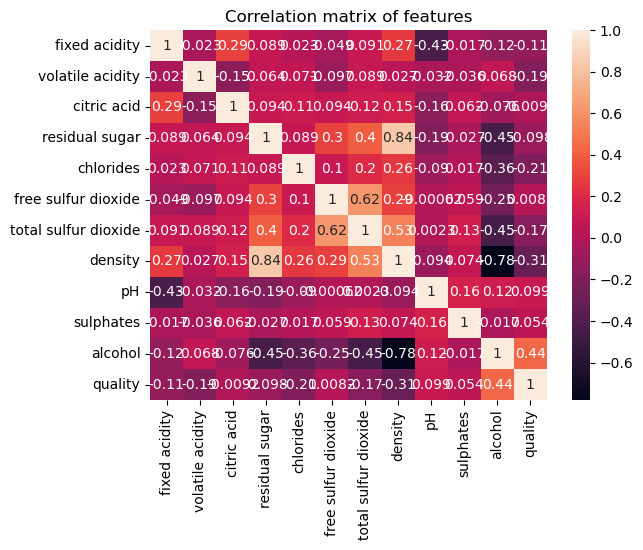

In [4]:
corr = data.corr()
sns.heatmap(corr, annot=True)
plt.title("Correlation matrix of features")
plt.show()

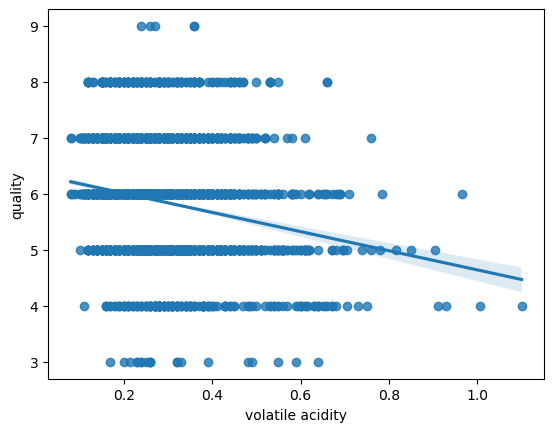

In [5]:
sns.regplot(x="volatile acidity", y="quality", data=data)
plt.show()

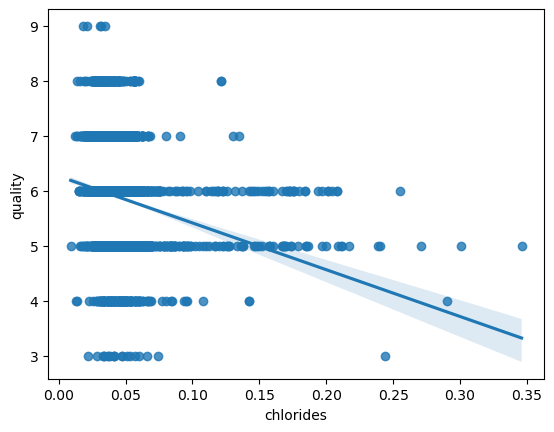

In [6]:
sns.regplot(x="chlorides", y="quality", data=data)
plt.show()

In [7]:
data = data.drop(['chlorides', 'volatile acidity'], axis=1)

In [8]:
X = data.iloc[:, :-1].values
y = data.iloc[:, -1].values

y = np.where(y <= 6, 0, 1)

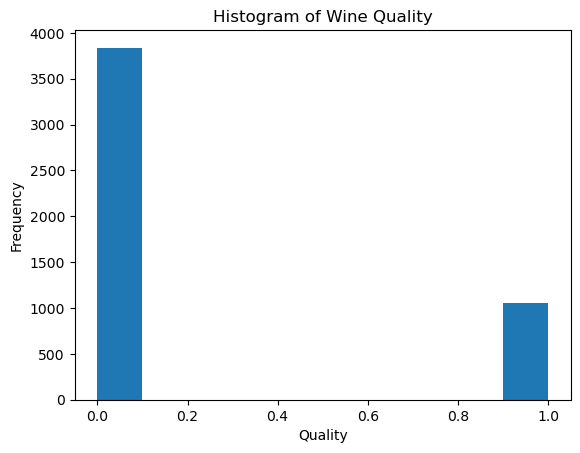

In [9]:
plt.hist(y)
plt.xlabel('Quality')
plt.ylabel('Frequency')
plt.title('Histogram of Wine Quality')
plt.show()

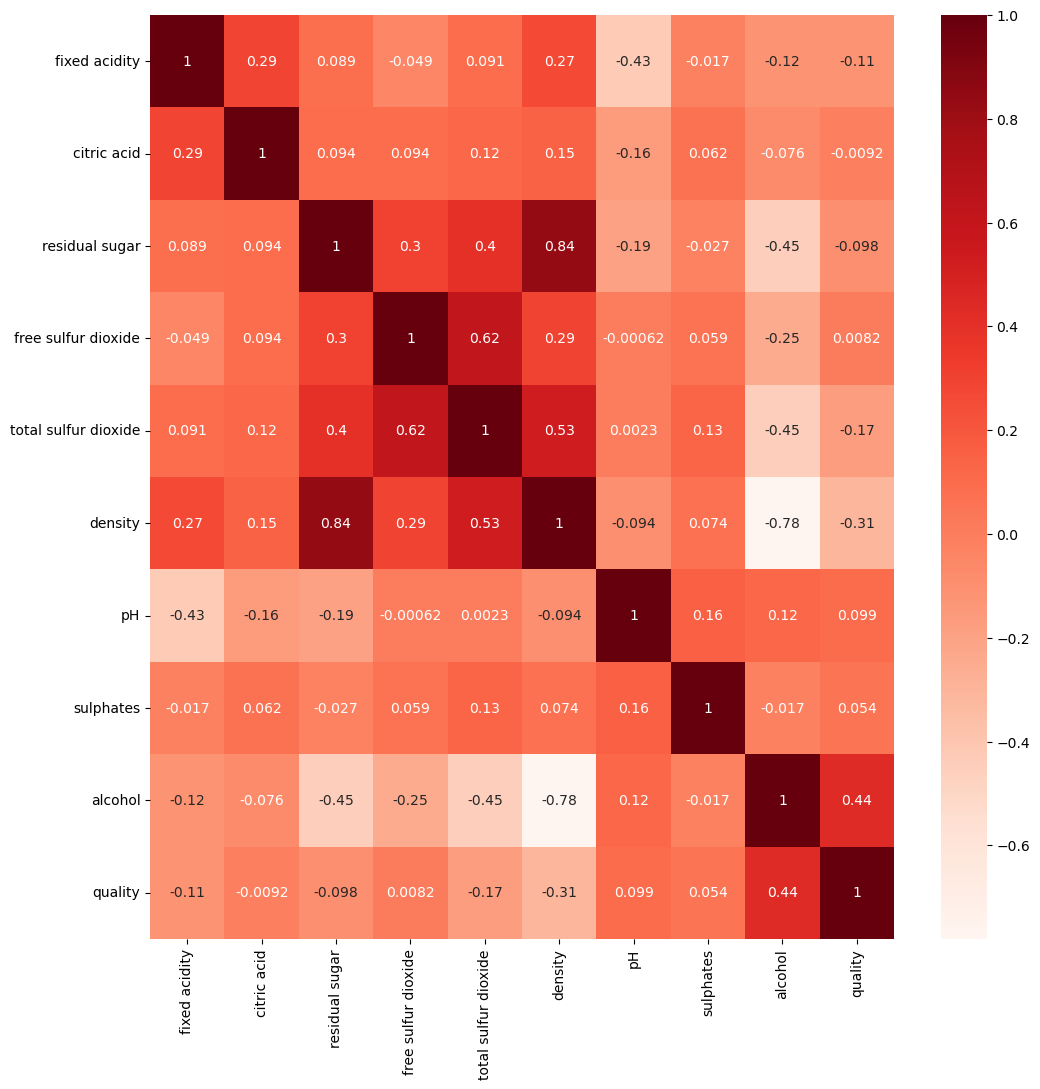

In [10]:
corr = data.corr()
plt.figure(figsize=(12, 12))
sns.heatmap(corr, annot=True, cmap=plt.cm.Reds)
plt.show()

In [11]:
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

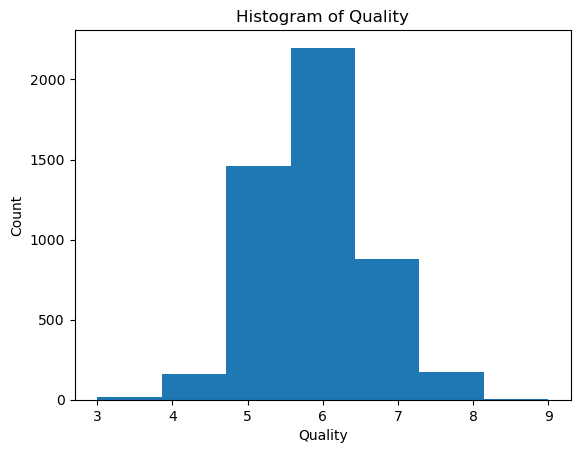

In [12]:
plt.hist(data["quality"], bins=7)
plt.xlabel("Quality")
plt.ylabel("Count")
plt.title("Histogram of Quality")
plt.show()

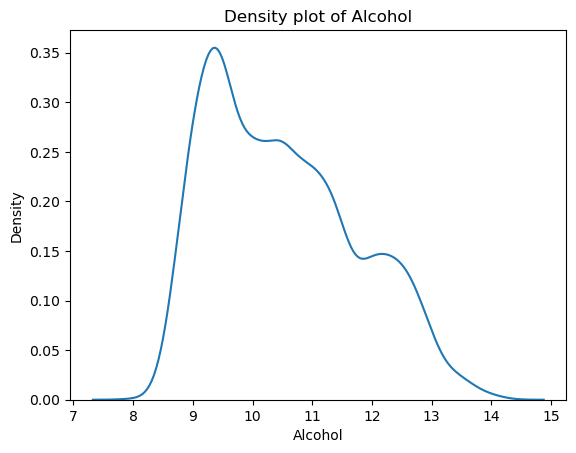

In [13]:
sns.kdeplot(x=data["alcohol"])
plt.xlabel("Alcohol")
plt.title("Density plot of Alcohol")
plt.show()

In [14]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [15]:
class_prob = calculate_class_prob(y_train)
mean = np.zeros((2, X_train.shape[1]))
var = np.zeros((2, X_train.shape[1]))
for i in range(2):
    mean[i], var[i] = calculate_mean_var(X_train[y_train == i])

    y_pred = predict(X_test, class_prob, mean, var)

accuracy_before_cv = np.mean(y_pred == y_test)
print("Accuracy before cross-validation:", accuracy_before_cv)

Accuracy before cross-validation: 0.6469387755102041


In [16]:
# Cross Validation
scaler = StandardScaler()
X = scaler.fit_transform(X)

selector = SelectKBest(f_classif, k=5)
X = selector.fit_transform(X, y)

In [17]:
K = 5

accuracies = []

fold_size = len(X) // K
for i in range(K):
    start, end = i * fold_size, (i + 1) * fold_size
    X_test, y_test = X[start:end], y[start:end]

    X_train = np.concatenate([X[:start], X[end:]], axis=0)
    y_train = np.concatenate([y[:start], y[end:]], axis=0)

    class_prob = calculate_class_prob(y_train)
    mean, var = np.zeros((2, X_train.shape[1])), np.zeros((2, X_train.shape[1]))
    for j in range(2):
        mean[j], var[j] = calculate_mean_var(X_train[y_train == j])
        y_pred = predict(X_test, class_prob, mean, var)

        accuracy = np.mean(y_pred == y_test)
        accuracies.append(accuracy)
mean_accuracy = np.mean(accuracies)
std_accuracy = np.std(accuracies)

In [18]:
print("Mean accuracy after cross-validation:", mean_accuracy)
print("Standard deviation of accuracy after cross-validation:", std_accuracy)

Mean accuracy after cross-validation: 0.7741573033707866
Standard deviation of accuracy after cross-validation: 0.04738132036402466


In [19]:
# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

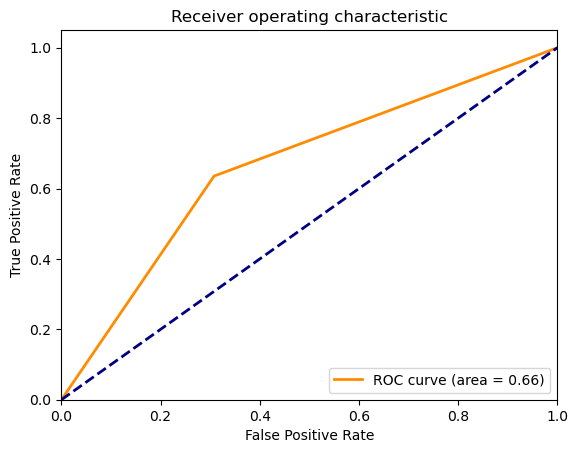

In [20]:
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

In [21]:
def confusion_matrix(y_true, y_pred):
    """
    Computes the confusion matrix for binary classification.
    """
    tp = np.sum((y_test == 1) & (y_pred == 1))
    tn = np.sum((y_test == 0) & (y_pred == 0))
    fp = np.sum((y_test == 0) & (y_pred == 1))
    fn = np.sum((y_test == 1) & (y_pred == 0))
    return np.array([[tn, fp], [fn, tp]])
def f1_score(y_true, y_pred):
    """
    Computes the F1 score for binary classification.
    """
    cm = confusion_matrix(y_true, y_pred)
    tp = cm[1, 1]
    fp = cm[0, 1]
    fn = cm[1, 0]
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    f1 = 2 * (precision * recall) / (precision + recall)
    return f1

In [22]:
cm = confusion_matrix(y_test, y_pred)
print("Confusion matrix:\n\n", cm)

Confusion matrix:

 [[560 249]
 [ 62 108]]


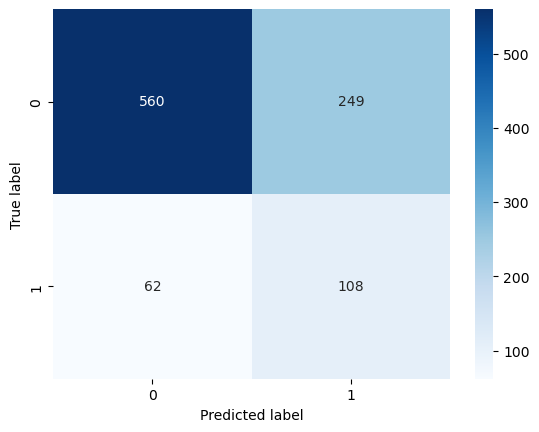

In [23]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

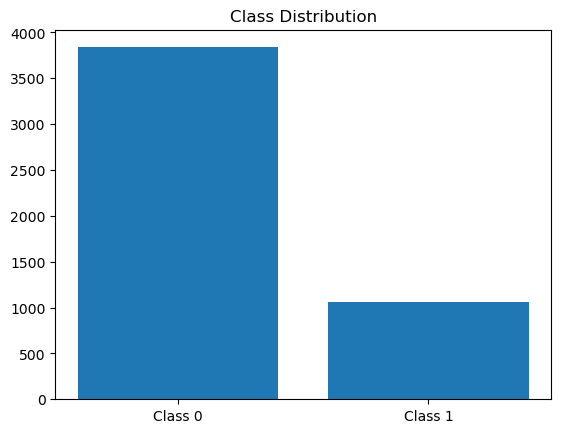

In [24]:
plt.bar([0, 1], [len(y[y==0]), len(y[y==1])])
plt.xticks([0, 1], ['Class 0', 'Class 1'])
plt.title('Class Distribution')
plt.show()

In [25]:
f1 = f1_score(y_test, y_pred)
print("F1 score:\n", f1)

F1 score:
 0.4098671726755218


# 

# 

# 